In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
file = '/content/drive/MyDrive/Rep1_MOB_count_matrix-1.tsv'
data_orig = pd.read_csv(file, sep='\t')
x = [float(i.partition('x')[0]) for i in data_orig.iloc[:,0]]
y = [float(i.partition('x')[2]) for i in data_orig.iloc[:,0]]
x_round = [int(i+0.5) for i in x] 
y_round = [int(i+0.5) for i in y]
data = []
    
#loop over genes
for i in range(1,data_orig.shape[1]):
    mat = np.zeros([32,32])
    #fill spatial arrays for each gene
    for x_, y_, val in zip(x_round, y_round, data_orig.iloc[:,i]):
        mat[y_,x_] = val
    #scaling the data on each gene from 0 to 1
    mat = mat/(mat.max())
    data.append(mat)
data = np.array(data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%tensorflow_version 1.x
print(tf.__version__)
tf.compat.v1.disable_eager_execution()

img_shape = (32, 32, 1)
batch_size = 16
latent_dim = 2
#Define encoder network
#Note that we are using keras functional API
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='sigmoid')(x)


shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)


z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
#Sampling from the distributions to obtain latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
    mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = Model(input_img, z)
#Define decoder network
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3,padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)
def vae_loss(input_img, z_decoded):
    input_img = K.flatten(input_img)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(input_img, z_decoded) 
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

vae = Model(input_img, z_decoded)
vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()
decoder.summary()
#load the data and split into train + test sets
cut_point = round(len(data) * 0.8)
x_train = data[:cut_point]
x_test = data[cut_point:]
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))


TensorFlow is already loaded. Please restart the runtime to change versions.
2.4.1
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 64)   36928       conv2d_1[0][0]                   
_________

In [16]:
vae.fit(x=x_train, y=x_train, shuffle=True, epochs=10, batch_size=batch_size)


Train on 13258 samples
Epoch 1/10
13258/13258 [==============================] - 52s 4ms/sample - loss: 0.0162
Epoch 2/10
13258/13258 [==============================] - 51s 4ms/sample - loss: 7.7458e-04
Epoch 3/10
13258/13258 [==============================] - 50s 4ms/sample - loss: 7.5923e-04
Epoch 4/10
13258/13258 [==============================] - 51s 4ms/sample - loss: 7.5323e-04
Epoch 5/10
13258/13258 [==============================] - 51s 4ms/sample - loss: 7.4983e-04
Epoch 6/10
13258/13258 [==============================] - 51s 4ms/sample - loss: 7.4756e-04
Epoch 7/10
13258/13258 [==============================] - 51s 4ms/sample - loss: 7.4513e-04
Epoch 8/10
13258/13258 [==============================] - 51s 4ms/sample - loss: 7.4317e-04
Epoch 9/10
13258/13258 [==============================] - 50s 4ms/sample - loss: 7.4172e-04
Epoch 10/10
13258/13258 [==============================] - 50s 4ms/sample - loss: 7.4092e-04


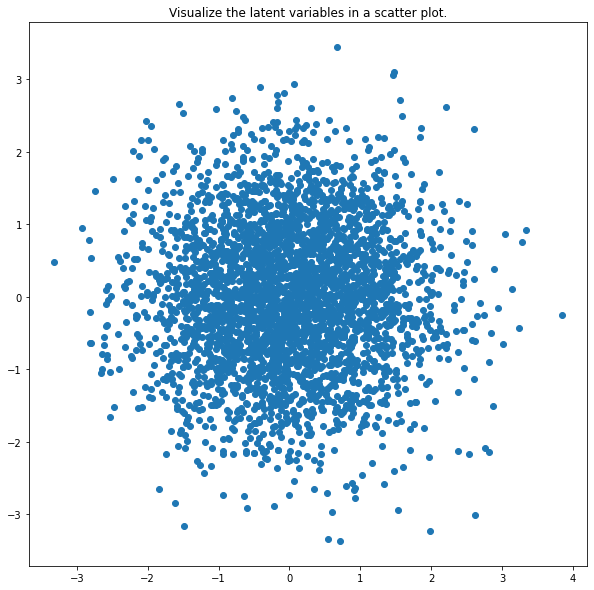

In [19]:
x_test_encoded = encoder.predict(x_test)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1])
plt.title('Visualize the latent variables in a scatter plot.')
plt.show()

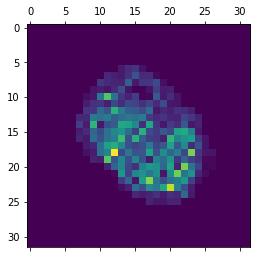

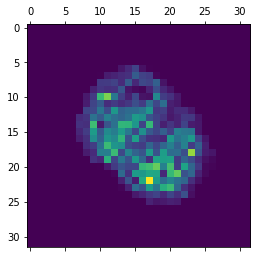

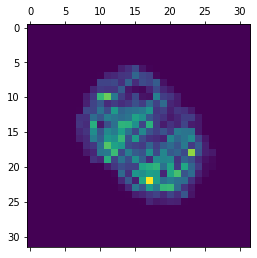

In [53]:
import random

p1 = random.sample(range(-8, 8),3)
p2 = random.sample(range(-4, 4),3)

parameter = np.array(list(zip(p1, p2)))
decoded = decoder.predict(params).reshape(3, 32, 32)

for index, param in enumerate(parameter):  

  plt.matshow(decoded[index])
  plt.show()